In [3]:
import pandas as pd
import numpy as np
import re
import string
import spacy
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction._stop_words import ENGLISH_STOP_WORDS
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

In [4]:
!python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 0.0/12.8 MB 165.2 kB/s eta 0:01:18
     --------------------------------------- 0.0/12.8 MB 245.8 kB/s eta 0:00:52
     --------------------------------------- 0.1/12.8 MB 297.7 kB/s eta 0:00:43
     --------------------------------------- 0.1/12.8 MB 374.1 kB/s eta 0:00:34
     --------------------------------------- 0.1/12.8 MB 423.5 kB/s eta 0:00:30
     --------------------------------------- 0.2/12.8 MB 459.5 kB/s eta 0:00:28
      -------------------------------------- 0.2/12.8 MB 513.4 kB/s eta 0:00:25
      -------------------------------------- 0.2/12.8 MB 461.0 kB/s eta 0:00:28
      -------------------------------------- 0.2/12.8 MB 461.0 kB/s eta 0:00:28
      -------------------------------------- 0.2/12.8 MB 461.0 kB/s eta 0:00:28
      -------------------------------------- 0.3/12.8 MB

### Набор данных
[
Spam or Not Spam Dataset](https://www.kaggle.com/datasets/ozlerhakan/spam-or-not-spam-dataset/)

In [5]:
data = pd.read_csv('spam_or_not_spam.csv')
data = data.astype({'email':'string'})
data.head()

,email,label
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0
1,martin a posted tassos papadopoulos the greek ...,0
2,man threatens explosion in moscow thursday aug...,0
3,klez the virus that won t die already the most...,0
4,in adding cream to spaghetti carbonara which ...,0


In [6]:
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2999 entries, 0 to 2999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   email   2999 non-null   string
 1   label   2999 non-null   int64 
dtypes: int64(1), string(1)
memory usage: 70.3 KB


In [7]:
data['label'].value_counts()

label
0    2500
1     499
Name: count, dtype: int64

### Очистка

Стоп-слова для английского языка в spaCy

In [8]:
nlp = spacy.load("en_core_web_sm")
stopwords = nlp.Defaults.stop_words
print(f'Spacy english stopwords size: {len(stopwords)}', end='\n\n')
' '.join(stopwords)

Spacy english stopwords size: 326



"whoever therein noone therefore enough himself be eight put seem seems yourselves did before most should very between serious ten wherever only too whereby even get it part below thence anywhere you 'll meanwhile hereby ’m your hereafter make after hers eleven would must we an off within as ours together moreover above my sometimes ‘ve well more along mine also except nobody others whole ’re became n't n‘t perhaps already thus in beforehand itself whereas keep no onto since give though n’t not while further doing if own somewhere twenty ‘m although can still another everything nor has ourselves anyone upon else take once really why afterwards done may first for used show say beside whereafter someone via anything these who what ’ll elsewhere otherwise regarding her empty formerly full are all least towards some rather wherein i will throughout thereafter six then quite various two becoming which alone across forty hereupon name whence ‘ll among could per was become how might of a that

Атрибуты [Token](https://spacy.io/api/token#attributes)

In [9]:
%%time

data['cleaned_text'] = data['email'].apply(
    lambda x: ' '.join(
        token.lemma_.lower() for token in nlp(x) if
        not token.is_stop
        and not token.is_punct
        and not token.is_digit
        and not token.like_email
        and not token.like_num
        and not token.is_space
    )
)
data.head()

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 0.0/12.8 MB 393.8 kB/s eta 0:00:33
     --------------------------------------- 0.1/12.8 MB 544.7 kB/s eta 0:00:24
     --------------------------------------- 0.1/12.8 MB 544.7 kB/s eta 0:00:24
     --------------------------------------- 0.1/12.8 MB 544.7 kB/s eta 0:00:24
     --------------------------------------- 0.1/12.8 MB 286.7 kB/s eta 0:00:45
     --------------------------------------- 0.1/12.8 MB 286.7 kB/s eta 0:00:45
     --------------------------------------- 0.1/12.8 MB 297.7 kB/s eta 0:00:43
     --------------------------------------- 0.1/12.8 MB 297.7 kB/s eta 0:00:43
     --------------------------------------- 0.1/12.8 MB 297.7 kB/s eta 

,email,label,cleaned_text
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0,date d number aug number number number number ...
1,martin a posted tassos papadopoulos the greek ...,0,martin post tassos papadopoulo greek sculptor ...
2,man threatens explosion in moscow thursday aug...,0,man threaten explosion moscow thursday august ...
3,klez the virus that won t die already the most...,0,klez virus win t die prolific virus klez conti...
4,in adding cream to spaghetti carbonara which ...,0,add cream spaghetti carbonara effect pasta mak...


#### CountVectorizer

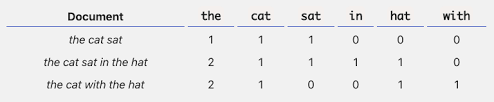

- приводит к нижнему регистру
- проводит токенизацию - `r"(?u)\b\w\w+\b"` (токены из 2 или более буквенно-цифровых символов, пунктуация полностью игнорируется и всегда рассматривается как разделитель токенов)
  - `(?u)` - флаг Unicode
  - `\b` - граница слова
  - `\w` - символы, которые могут входить в состав слов, включая числа и подчёркивание
  - `\+` - 1 и более повторений предшествующего выражения
- фильтрует стоп-слова

##### Train/test split & fit

In [10]:
X_train, X_test, y_train, y_test = train_test_split(data['cleaned_text'], data['label'], random_state=2023)

In [11]:
vectorizer = CountVectorizer(max_df=0.7, min_df=0.003) # max_df фильтрует corpus-specific stop words
X_train_vectorized = vectorizer.fit_transform(X_train) 
X_test_vectorized = vectorizer.transform(X_test)

##### Бейзлайн

Константное предсказание

In [12]:
dummy_clf = DummyClassifier(strategy="most_frequent").fit(X_train_vectorized, y_train)
preds = dummy_clf.predict(X_test_vectorized)
print(classification_report(y_test, preds, zero_division=0))

              precision    recall  f1-score   support

           0       0.82      1.00      0.90       616
           1       0.00      0.00      0.00       134

    accuracy                           0.82       750
   macro avg       0.41      0.50      0.45       750
weighted avg       0.67      0.82      0.74       750



Логистическая регрессия

In [13]:
logreg = LogisticRegression().fit(X_train_vectorized, y_train)
preds_count_vec = logreg.predict(X_test_vectorized)
print(classification_report(y_test, preds_count_vec))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       616
           1       0.98      0.93      0.95       134

    accuracy                           0.98       750
   macro avg       0.98      0.96      0.97       750
weighted avg       0.98      0.98      0.98       750



##### Переопределение токенизатора, препроцессинга

In [14]:
def custom_tokenize(text):
  text = re.sub(r'[^a-zA-Z ]', '', text)
  return text.split()

In [15]:
custom_vectorizer = CountVectorizer(
    max_df=0.7,
    min_df=0.003,
    tokenizer=custom_tokenize, # аналогично можно переопределить preprocessor
)
X_train_vectorized = custom_vectorizer.fit_transform(X_train)
X_test_vectorized = custom_vectorizer.transform(X_test)

c:\Users\User\PycharmProjects\nlp_course\venv\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [16]:
logreg = LogisticRegression().fit(X_train_vectorized, y_train)
preds = logreg.predict(X_test_vectorized)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       616
           1       0.95      0.93      0.94       134

    accuracy                           0.98       750
   macro avg       0.97      0.96      0.96       750
weighted avg       0.98      0.98      0.98       750



Было:

In [17]:
print(classification_report(y_test, preds_count_vec))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       616
           1       0.98      0.93      0.95       134

    accuracy                           0.98       750
   macro avg       0.98      0.96      0.97       750
weighted avg       0.98      0.98      0.98       750



Стало работать хуже с новым токенизатором.

### Tf-Idf

В объемном корпусе некоторые слова будут присутствовать в большом количестве документов (текстов), а значит, они несут очень мало значимой информации о фактическом содержании документа.

Для решения этой проблемы можно использовать Tf-Idf подход

Цель использования tf-idf состоит в том, чтобы уменьшить влияние токенов, которые очень часто встречаются в данном корпусе и, следовательно, эмпирически менее информативны, чем признаки, которые встречаются малой части корпуса



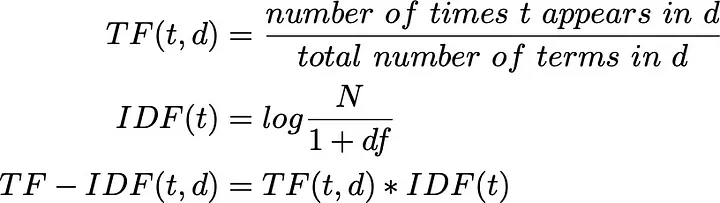

#### Отличия в реализации Sklearn

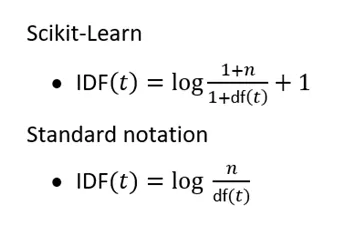

Также в Scikit-Learn результирующие векторы TF-IDF нормализуются по евклидовой норме, что облегчает расчет cosine similarity:
`The cosine similarity between two vectors is their dot product when l2 norm has been applied`

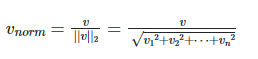

In [18]:
pipe = Pipeline(
    steps=[
        ('tfidf', TfidfVectorizer()),
        ('clf', LogisticRegression())
    ]
).fit(X_train, y_train)
preds = pipe.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98       616
           1       1.00      0.77      0.87       134

    accuracy                           0.96       750
   macro avg       0.98      0.88      0.92       750
weighted avg       0.96      0.96      0.96       750



Сравним с CountVectorizer

In [19]:
print(classification_report(y_test, preds_count_vec))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       616
           1       0.98      0.93      0.95       134

    accuracy                           0.98       750
   macro avg       0.98      0.96      0.97       750
weighted avg       0.98      0.98      0.98       750



Для разных задач нужно оптимизировать разные метрики, так что оба решения имеют место быть, к тому же, их еще можно запускать на разных параметрах.

#### Оптимизация гиперпараметров пайплайна целиком - HalvingGridSearchCV

##### Логистическая регрессия

In [20]:
pipe = Pipeline(
    steps=[
        ('counter', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', LogisticRegression())
    ]
)

In [21]:
parameter_grid = {
    "counter__max_df": np.linspace(0.3, 0.7, 10),
    "counter__min_df": [0.0, 0.001, 0.003, 0.005],
    "counter__ngram_range": ((1, 1), (1, 2)),  # слова или биграммы
    "tfidf__norm": ("l1", "l2"),
    "clf__C": np.linspace(0.1, 1, 10),
}

In [22]:
%%time

grid_search = HalvingGridSearchCV(
    pipe,
    param_grid=parameter_grid,
    n_jobs=-1,
    verbose=1,
    cv=5,
    scoring='accuracy',
    random_state=42,
)
grid_search.fit(X_train, y_train)

n_iterations: 5
n_required_iterations: 7
n_possible_iterations: 5
min_resources_: 20
max_resources_: 2249
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1600
n_resources: 20
Fitting 5 folds for each of 1600 candidates, totalling 8000 fits


----------
iter: 1
n_candidates: 534
n_resources: 60
Fitting 5 folds for each of 534 candidates, totalling 2670 fits
----------
iter: 2
n_candidates: 178
n_resources: 180
Fitting 5 folds for each of 178 candidates, totalling 890 fits
----------
iter: 3
n_candidates: 60
n_resources: 540
Fitting 5 folds for each of 60 candidates, totalling 300 fits
----------
iter: 4
n_candidates: 20
n_resources: 1620
Fitting 5 folds for each of 20 candidates, totalling 100 fits
CPU times: total: 2min 29s
Wall time: 4min 25s


HalvingGridSearchCV(estimator=Pipeline(steps=[('counter', CountVectorizer()),
                                              ('tfidf', TfidfTransformer()),
                                              ('clf', LogisticRegression())]),
                    n_jobs=-1,
                    param_grid={'clf__C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                                'counter__max_df': array([0.3       , 0.34444444, 0.38888889, 0.43333333, 0.47777778,
       0.52222222, 0.56666667, 0.61111111, 0.65555556, 0.7       ]),
                                'counter__min_df': [0.0, 0.001, 0.003, 0.005],
                                'counter__ngram_range': ((1, 1), (1, 2)),
                                'tfidf__norm': ('l1', 'l2')},
                    random_state=42, scoring='accuracy', verbose=1)

In [23]:
plt.rcParams["figure.figsize"] = (12, 8)

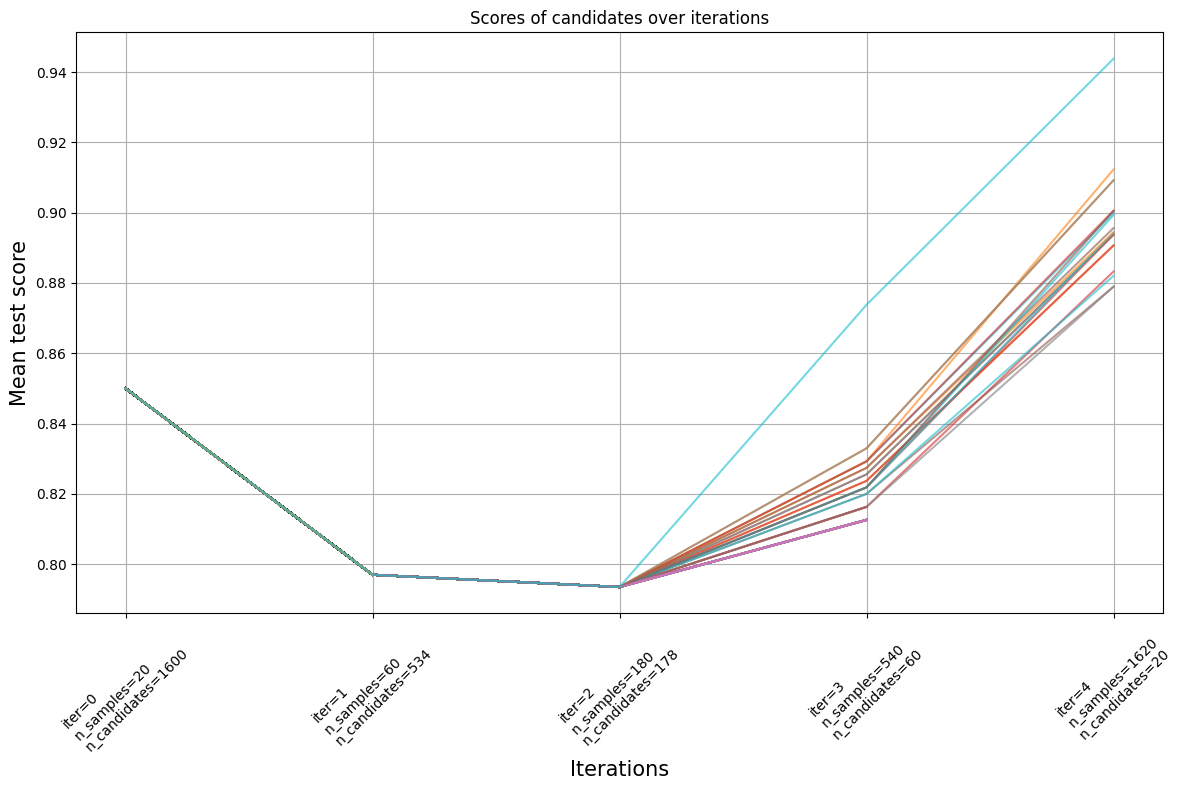

In [24]:
results = pd.DataFrame(grid_search.cv_results_)
results["params_str"] = results.params.apply(str)
results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
mean_scores = results.pivot(
    index="iter",
    columns="params_str",
     values="mean_test_score",
)
ax = mean_scores.plot(legend=False, alpha=0.6)

labels = [
    f"iter={i}\nn_samples={grid_search.n_resources_[i]}\nn_candidates={grid_search.n_candidates_[i]}"
    for i in range(grid_search.n_iterations_)
]

ax.set_xticks(range(grid_search.n_iterations_))
ax.set_xticklabels(labels, rotation=45, multialignment="left")
ax.set_title("Scores of candidates over iterations")
ax.set_ylabel("Mean test score", fontsize=15)
ax.set_xlabel("Iterations", fontsize=15)
plt.tight_layout()
plt.grid()
plt.show()

In [25]:
grid_search.best_score_

0.9437927607690251

In [26]:
preds = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       616
           1       1.00      0.85      0.92       134

    accuracy                           0.97       750
   macro avg       0.98      0.93      0.95       750
weighted avg       0.97      0.97      0.97       750



In [27]:
##### Дерево решений

In [28]:
pipe = Pipeline(
    steps=[
        ('counter', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', DecisionTreeClassifier())
    ]
)

parameter_grid = {
    "counter__max_df": np.linspace(0.3, 0.7, 10),
    "counter__min_df": [0.0, 0.001, 0.003, 0.005],
    "counter__ngram_range": ((1, 1), (1, 2)),  # слова или биграммы
    "tfidf__norm": ("l1", "l2")
}


In [29]:
%%time

grid_search = HalvingGridSearchCV(
    pipe,
    param_grid=parameter_grid,
    n_jobs=-1,
    verbose=1,
    cv=5,
    scoring='accuracy',
    random_state=42,
)
grid_search.fit(X_train, y_train)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 27
max_resources_: 2249
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 160
n_resources: 27
Fitting 5 folds for each of 160 candidates, totalling 800 fits


----------
iter: 1
n_candidates: 54
n_resources: 81
Fitting 5 folds for each of 54 candidates, totalling 270 fits
----------
iter: 2
n_candidates: 18
n_resources: 243
Fitting 5 folds for each of 18 candidates, totalling 90 fits
----------
iter: 3
n_candidates: 6
n_resources: 729
Fitting 5 folds for each of 6 candidates, totalling 30 fits
----------
iter: 4
n_candidates: 2
n_resources: 2187
Fitting 5 folds for each of 2 candidates, totalling 10 fits
CPU times: total: 17.1 s
Wall time: 36.9 s


HalvingGridSearchCV(estimator=Pipeline(steps=[('counter', CountVectorizer()),
                                              ('tfidf', TfidfTransformer()),
                                              ('clf',
                                               DecisionTreeClassifier())]),
                    n_jobs=-1,
                    param_grid={'counter__max_df': array([0.3       , 0.34444444, 0.38888889, 0.43333333, 0.47777778,
       0.52222222, 0.56666667, 0.61111111, 0.65555556, 0.7       ]),
                                'counter__min_df': [0.0, 0.001, 0.003, 0.005],
                                'counter__ngram_range': ((1, 1), (1, 2)),
                                'tfidf__norm': ('l1', 'l2')},
                    random_state=42, scoring='accuracy', verbose=1)

In [30]:
preds = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.99      0.96      0.97       616
           1       0.83      0.94      0.88       134

    accuracy                           0.96       750
   macro avg       0.91      0.95      0.93       750
weighted avg       0.96      0.96      0.96       750



##### Наивный Байесовский классификатор

In [31]:
pipe = Pipeline(
    steps=[
        ('counter', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', MultinomialNB())
    ]
)

parameter_grid = {
    "counter__max_df": np.linspace(0.3, 0.7, 10),
    "counter__min_df": [0.0, 0.001, 0.003, 0.005],
    "counter__ngram_range": ((1, 1), (1, 2)),  # слова или биграммы
    "tfidf__norm": ("l1", "l2"),
}


In [32]:
%%time

grid_search = HalvingGridSearchCV(
    pipe,
    param_grid=parameter_grid,
    n_jobs=-1,
    verbose=1,
    cv=5,
    scoring='accuracy',
    random_state=42,
)
grid_search.fit(X_train, y_train)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 27
max_resources_: 2249
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 160
n_resources: 27
Fitting 5 folds for each of 160 candidates, totalling 800 fits


----------
iter: 1
n_candidates: 54
n_resources: 81
Fitting 5 folds for each of 54 candidates, totalling 270 fits
----------
iter: 2
n_candidates: 18
n_resources: 243
Fitting 5 folds for each of 18 candidates, totalling 90 fits
----------
iter: 3
n_candidates: 6
n_resources: 729
Fitting 5 folds for each of 6 candidates, totalling 30 fits
----------
iter: 4
n_candidates: 2
n_resources: 2187
Fitting 5 folds for each of 2 candidates, totalling 10 fits
CPU times: total: 10.4 s
Wall time: 19.7 s


HalvingGridSearchCV(estimator=Pipeline(steps=[('counter', CountVectorizer()),
                                              ('tfidf', TfidfTransformer()),
                                              ('clf', MultinomialNB())]),
                    n_jobs=-1,
                    param_grid={'counter__max_df': array([0.3       , 0.34444444, 0.38888889, 0.43333333, 0.47777778,
       0.52222222, 0.56666667, 0.61111111, 0.65555556, 0.7       ]),
                                'counter__min_df': [0.0, 0.001, 0.003, 0.005],
                                'counter__ngram_range': ((1, 1), (1, 2)),
                                'tfidf__norm': ('l1', 'l2')},
                    random_state=42, scoring='accuracy', verbose=1)

In [33]:
preds = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       616
           1       0.97      0.93      0.95       134

    accuracy                           0.98       750
   macro avg       0.98      0.96      0.97       750
weighted avg       0.98      0.98      0.98       750



Accuracy лучше всего у Байесовского классификатора - 0.98, потом у логистической регресссии - 0.97, потом дерево решений - 0.96.